In [1]:
# # IMPORTS
# astronomy
from astropy.io import fits
# plotting 
from matplotlib.ticker import AutoMinorLocator
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
# data 
import numpy as np
# my python files 
import match
import v2_AGN_DataAndPlotting as adp
import v2_SED as SED

# Prep Data

In [2]:
def PrintNumber(myDict) :
    for key,val in myDict.items():
        if(isinstance(val,np.ndarray)):
            print(key,'\t',len(val)) 
        elif(isinstance(val,dict)):
            print(key,end='')
            for key1,val1 in val.items():
                if(isinstance(val1,dict)) : 
                    print('\t',key1,end='')
                    for key2,val2 in val1.items():
                        print('\t\t',key2,'\t',len(val2))
                else : 
                    print('\t',key1,'\t',len(val1))

In [3]:
# read AGN IDs
agnIDs = adp.ReadFile(adp.path_csv+'\\v2_AGNid_tricolor.csv')

# convert agnIDs into dict of integer numpy arrays 
agnIDs_dict = {
    'RED' : np.array(agnIDs[0], dtype=int),
    'GRN' : np.array(agnIDs[1], dtype=int),
    'BLU' : np.array(agnIDs[2], dtype=int)
}

# verify nmber of sources
PrintNumber(agnIDs_dict)

Cropped:  ['Row 1 = MIR exclusive AGN with id, redshift, and IRAC (n=472). Row 2 = MIR-X-ray inclusive AGN with id, redshift, and IRAC (n=663). Row 3 = X-ray exclusive AGN with id, redshift, and IRAC (n=1717). ']
RED 	 472
GRN 	 663
BLU 	 1717


In [4]:
# get redshifts
zDict = adp.ReadRedshifts(file=adp.path_cat+'\COSMOS_z_matches.csv')

Cropped:  ['ID', 'z']
Number of redshifts: 485793


In [5]:
agnInfo = {}
for key,val in agnIDs_dict.items():
    # match redshift to AGN
    key_zid, key_idz = match.match(zDict['ID'], val)
    agnInfo[key] = {
        'ID' : val[key_idz],
        'z'  : zDict['z'][key_zid]
    }
# verify number of sources
PrintNumber(agnInfo)

RED	 ID 	 472
	 z 	 472
GRN	 ID 	 663
	 z 	 663
BLU	 ID 	 1717
	 z 	 1717


In [6]:
# open COSMOS 2020 catalog file and get data 
with fits.open(adp.path_cat+'\\COSMOS2020_CLASSIC_R1_v2.0_master.fits') as hdul20:
    data20 = hdul20[1].data

In [7]:
# open COSMOS 2016 catalog file and get data 
with fits.open(adp.path_cat+'\\chandra_COSMOS_legacy_opt_NIR_counterparts_20160113_4d.fits') as hdul16:
    data16 = hdul16[1].data
    cols16 = hdul16[1].columns


# get data arrays from columns
id_data16 = np.array(data16['id_k_uv'])
print('.', end='')

# using210=True
using210=False
if(using210):
    Lx_data16 = np.array(data16['Lx_210']) # x-ray luminosity in the 2-10 KeV band
    print('.', end='')
    kx_data16 = np.array(data16['abs_corr_210'])  # absorbtion correction coefficient in the 0.5-10 KeV band
    print('.', end='')
else : 
    Lx_data16 = np.array(data16['Lx_0510']) # x-ray luminosity in the 0.5-10 KeV band
    print('.', end='')
    kx_data16 = np.array(data16['abs_corr_0510'])  # absorbtion correction coefficient in the 0.5-10 KeV band
    print('.', end='')


...

In [8]:
# get starting info 
Fnu_uJy = SED.GetPhotometry(data20, print=False)
IDs_all = SED.GetID(data20, print=False)
lam_A   = SED.GetObservedWavelengths_A(print=False)

In [9]:
# interpolates the luminosity at 1um
def Lum_at6um(lamFlam,lam,z) :
    lum_list = []
    for x,y,z in zip(lam,lamFlam,z) : 
        # interpolate
        f = SED.Interpolate_log(x,y)
        # normalize at 1um
        Fnu_at1um = SED.Flog_X(f,6*1E+4) # 6A * 10^4 = 6um
        # convert to luminosity
        lum_list.append(SED.Flux_to_Lum(Fnu_at1um,z))
    return(np.array(lum_list))

In [10]:
for key,val in agnInfo.items():
    # match photometry to AGN
    key_agn, key_phot = match.match(val['ID'], IDs_all)
    # get phot
    Fnu = Fnu_uJy[key_phot]
    # get rest wavelength 
    lamR = SED.ConvertToRestWavelength(val['z'], print=False)
    # get energy density and normalize
    lamFlam = SED.ConvertToEnergyDensity(lamR, Fnu, print=False)
    # get luminosity at 1um
    lum6um = np.log10( Lum_at6um(lamFlam, lamR, val['z'], ) )
    # append info
    # val['Rest Wavelength'] = lamR
    # val['Energy Density'] = lamFlam
    val['L(6um)'] = lum6um

# verify number of sources
PrintNumber(agnInfo)

RED	 ID 	 472
	 z 	 472
	 L(6um) 	 472
GRN	 ID 	 663
	 z 	 663
	 L(6um) 	 663
BLU	 ID 	 1717
	 z 	 1717
	 L(6um) 	 1717


In [11]:
agnInfo_yX = {}
agnInfo_nX = {}
for colorKey,agnValDict in agnInfo.items():
    ### get AGN with a good Lx
    # get key to the IDs from C-COSMOS data, which are parallel to Xray data
    key_agnID, key_id = match.match(agnValDict['ID'], id_data16)
    # get xray luminosity data
    Lx_agn = adp.IntrinsicLuminosity(Lx_data16[key_id], kx_data16[key_id])
    mask_Lx_agn_good = Lx_agn > 0
    # build 'yes Xray' dict 
    agnDict_yX = {}
    for dictKey, dictVal in agnValDict.items() : 
        agnDict_yX[dictKey] = dictVal[(key_agnID[mask_Lx_agn_good])]
    agnDict_yX['Lx'] = Lx_agn[mask_Lx_agn_good]
    ### get remaining AGN
    # match all agn to those with Lx
    key_fullLx, key_Lx = match.match(agnValDict['ID'], agnDict_yX['ID'])
    # get AGN without Lx
    mask_noLx = np.ones(agnValDict['ID'].shape, dtype=bool)
    mask_noLx[key_fullLx] = False 
    # build 'no Xray' dict 
    agnDict_nX = {}
    for dictKey, dictVal in agnValDict.items() : 
        agnDict_nX[dictKey] = dictVal[(mask_noLx)]
    ### finish
    agnInfo_yX[colorKey] = agnDict_yX
    agnInfo_nX[colorKey] = agnDict_nX

# verify number of sources
print('~~~~ yX ~~~~~')
PrintNumber(agnInfo_yX)
print('~~~~ nX ~~~~~')
PrintNumber(agnInfo_nX) # only RED should have nX

~~~~ yX ~~~~~
RED	 ID 	 25
	 z 	 25
	 L(6um) 	 25
	 Lx 	 25
GRN	 ID 	 663
	 z 	 663
	 L(6um) 	 663
	 Lx 	 663
BLU	 ID 	 1717
	 z 	 1717
	 L(6um) 	 1717
	 Lx 	 1717
~~~~ nX ~~~~~
RED	 ID 	 447
	 z 	 447
	 L(6um) 	 447
GRN	 ID 	 0
	 z 	 0
	 L(6um) 	 0
BLU	 ID 	 0
	 z 	 0
	 L(6um) 	 0


In [12]:
# returns array of ( min <= z < max )
def GetMaskFromRedshiftsInRange(
        zArr,    # np array of z  
        min=0,   # minimum
        max=99,  # maximum 
        incusiveMin=False,
) : 
    # get mask of indecies that are in redshift range (true)
    if(incusiveMin):
        return (zArr >= min) & (zArr < max)
    else: 
        return (zArr >  min) & (zArr <= max)

In [13]:
def GetAGNinZrange(agnInfo_Xx : dict[str,dict[str,np.array]]):
    agnInfo_xX_byZ = {}
    for colorKey,agnDict in agnInfo_Xx.items() : 
        agnInfo_xX_byZ[colorKey] = {}
        # get masks for each redshift bin 
        zArray = agnDict['z']
        zMasks = {
            '$0 < z \leq 1$'   : GetMaskFromRedshiftsInRange(zArray,          max=1  ),
            '$1 < z \leq 1.5$' : GetMaskFromRedshiftsInRange(zArray, min=1,   max=1.5),
            '$1.5 < z \leq 2$' : GetMaskFromRedshiftsInRange(zArray, min=1.5, max=2  ),
            '$2 < z \leq 3$'   : GetMaskFromRedshiftsInRange(zArray, min=2,   max=3  ),
            '$3 < z \leq 6$'   : GetMaskFromRedshiftsInRange(zArray, min=3           )
        }
        for zKey, zArr in zMasks.items() : 
            agnInfo_xX_byZ[colorKey][zKey] = {}
            for agnDictKey, agnDictVal in agnDict.items() : 
                agnInfo_xX_byZ[colorKey][zKey][agnDictKey] = agnDictVal[zArr]
    return agnInfo_xX_byZ

agnInfo_yX_byZ = GetAGNinZrange(agnInfo_yX)
agnInfo_nX_byZ = GetAGNinZrange(agnInfo_nX)

# verify number of sources
print('~~~~ yX ~~~~~')
PrintNumber(agnInfo_yX_byZ)
print('~~~~ nX ~~~~~')
PrintNumber(agnInfo_nX_byZ) # only RED should have nX

~~~~ yX ~~~~~
RED	 $0 < z \leq 1$		 ID 	 25
		 z 	 25
		 L(6um) 	 25
		 Lx 	 25
	 $1 < z \leq 1.5$		 ID 	 0
		 z 	 0
		 L(6um) 	 0
		 Lx 	 0
	 $1.5 < z \leq 2$		 ID 	 0
		 z 	 0
		 L(6um) 	 0
		 Lx 	 0
	 $2 < z \leq 3$		 ID 	 0
		 z 	 0
		 L(6um) 	 0
		 Lx 	 0
	 $3 < z \leq 6$		 ID 	 0
		 z 	 0
		 L(6um) 	 0
		 Lx 	 0
GRN	 $0 < z \leq 1$		 ID 	 100
		 z 	 100
		 L(6um) 	 100
		 Lx 	 100
	 $1 < z \leq 1.5$		 ID 	 151
		 z 	 151
		 L(6um) 	 151
		 Lx 	 151
	 $1.5 < z \leq 2$		 ID 	 161
		 z 	 161
		 L(6um) 	 161
		 Lx 	 161
	 $2 < z \leq 3$		 ID 	 208
		 z 	 208
		 L(6um) 	 208
		 Lx 	 208
	 $3 < z \leq 6$		 ID 	 43
		 z 	 43
		 L(6um) 	 43
		 Lx 	 43
BLU	 $0 < z \leq 1$		 ID 	 386
		 z 	 386
		 L(6um) 	 386
		 Lx 	 386
	 $1 < z \leq 1.5$		 ID 	 536
		 z 	 536
		 L(6um) 	 536
		 Lx 	 536
	 $1.5 < z \leq 2$		 ID 	 396
		 z 	 396
		 L(6um) 	 396
		 Lx 	 396
	 $2 < z \leq 3$		 ID 	 339
		 z 	 339
		 L(6um) 	 339
		 Lx 	 339
	 $3 < z \leq 6$		 ID 	 60
		 z 	 60
		 L(6um) 	 60
		 Lx 	 60
~~~~

# Plot

In [14]:
def FuncStern(x) : 
    # y = 40.981 + 1.024x - 0.047x^2
    #   where: 
    #       y = log (Lx) 
    #       x = log (L(6um) / 1e41) = log (L(6um)) - 41
    y = (40.981 + ( 1.024 * (x - 41) ) - ( 0.047 * ((x - 41) ** 2) ))
    if(not using210):    # .5-10 <-- 2-10 should increace 
        #   y = log (Lx * 1.64) = log (Lx) + log( 1.64 ) 
        y = y + np.log10(1.64)
    return y

def DrawSternLine(ax, xmin=40, xmax=50, using210=True) : 
    x = np.linspace(xmin, xmax, 100)
    y = FuncStern(x)
    ax.plot(x,y, c='k')

In [40]:
def PlotTricolor_ax(
    ax,
    x_red, y_red, # x = L(6um), y = Lx
    x_grn, y_grn,
    x_blu, y_blu,
    fullText='',
    using210=True,
) :
    # plot data
    ax.scatter(x_blu, y_blu, marker='s', c=adp.c_xray,     s=3, label='Exclusive X-ray (n='+str(len(x_blu))+')')
    ax.scatter(x_red, y_red, marker='^', c=adp.c_ir,       s=3, label='Exclusive MIR (n='+  str(len(x_red))+')')
    ax.scatter(x_grn, y_grn, marker='o', c=adp.c_ir_xray,  s=3, label='Inclusive (n='+      str(len(x_grn))+')')
    DrawSternLine(ax, using210=using210)
    adp.PlotContours_ax( ax, np.concatenate([x_blu,x_red,x_grn]), np.concatenate([y_blu,y_red,y_grn]) )
    # decorations
    adp.AddText_n_ax(ax,len(x_blu)+len(x_red)+len(x_grn), pre='$\mathrm{N_{total}}$ = ')
    if(fullText != '') : adp.AddText_z_ax(ax, fullText)
    # axis settings
    ax.set_aspect('equal')
    ax.set_adjustable('box') 
    ax.set_xlim([41.5,47.5])
    ax.set_ylim([41.5,46])
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))

In [41]:
def PlotResidual(
    ax,
    x_red,
    y_red,
    x_grn,
    y_grn,
    x_blu,
    y_blu,
    func=FuncStern,
    nText=False,
    zText='',
    linestyle='-'
) : 
    # get difference for residual
    res_red = y_red - func(x_red)
    res_grn = y_grn - func(x_grn)
    res_blu = y_blu - func(x_blu)
    # plot data
    ax.scatter(x_blu, res_blu, marker='s', s=2, c=adp.c_xray    )
    ax.scatter(x_red, res_red, marker='^', s=2, c=adp.c_ir      )
    ax.scatter(x_grn, res_grn, marker='o', s=2, c=adp.c_ir_xray )
    ax.axhline(y=0, xmin=0, xmax=99, color='k', linestyle=linestyle, linewidth=1)
    adp.PlotContours_ax( ax, np.concatenate([x_blu,x_red,x_grn]), np.concatenate([res_blu,res_red,res_grn]) )
    # deco
    if(zText != '') : adp.AddText_z_ax(ax, zText)
    if(nText) : adp.AddText_n_ax(ax,len(x_blu)+len(x_red)+len(x_grn), pre='$\mathrm{N_{total}}$ = ')
    # axis settings
    ax.set_xlim([41.5,47.5])
    ax.set_ylim([-2.5,2.5])
    ax.set_adjustable('box') 
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))

In [43]:
def PlotLine(ax,a,b,xmin,xmax,linestyle='--') : 
    x = np.linspace(xmin,xmax)
    ax.plot(x, a*x+b, color='k', linestyle=linestyle, linewidth=1)    
    print('y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x')

In [69]:
def AddRedLineStuff(ax, agnInfo_nX_byZ) : 
    # collect data
    nx = np.array([])
    for zrange, agninfodict in agnInfo_nX_byZ['RED'].items() : 
        nx = np.concatenate((nx,agninfodict['L(6um)']))
    # stats
    center = np.mean(nx)
    std = np.std(nx) 
    print('STATS:\t', center-std, center, center+std)
    print('STERN:\t', FuncStern(center-std), FuncStern(center), FuncStern(center+std))
    for axi in ax : 
        # draw average line 
        axi.axvline( center, 0,1, c=adp.c_ir, linewidth=1, linestyle='dotted' )
        # draw 1 std dev from mean 
        axi.axvline( center+std, 0,1, c=adp.c_ir, linewidth=1, linestyle=(0, (1, 5)) ) # spaced dotted line
        axi.axvline( center-std, 0,1, c=adp.c_ir, linewidth=1, linestyle=(0, (1, 5)) )


In [45]:
def AddRedBoxStuff(ax, agnInfo_nX_byZ) : 
    # collect data
    nx = np.array([])
    for zrange, agninfodict in agnInfo_nX_byZ['RED'].items() : 
        nx = np.concatenate((nx,agninfodict['L(6um)']))
    # draw average line 
    center = np.mean(nx)
    ax[0].plot( (center,center), (41,43), c=adp.c_ir, linewidth=1, linestyle='dotted' )
    ax[1].axvline( center, 0,1, c=adp.c_ir, linewidth=1, linestyle='dotted' )
    # full range 
    point = (min(nx), 41.0) # bottom left 
    width = max(nx) - min(nx)
    height = 43.0 - 41.0
    ax[0].add_patch(Rectangle(point,width,height,
                            facecolor=adp.c_ir,
                            alpha=.1))
    # one std dev from mean
    std = np.std(nx) 
    point = (center-std, 41.0) # bottom left 
    width = 2*std
    ax[0].add_patch(Rectangle(point,width,height,
                            facecolor=adp.c_ir,
                            alpha=.1))


y = 26.42 + 0.39x
STATS:	 43.50333493736798 44.756168330298806 46.00900172322963
STERN:	 43.464724590906094 44.379046593573314 45.145826994258925


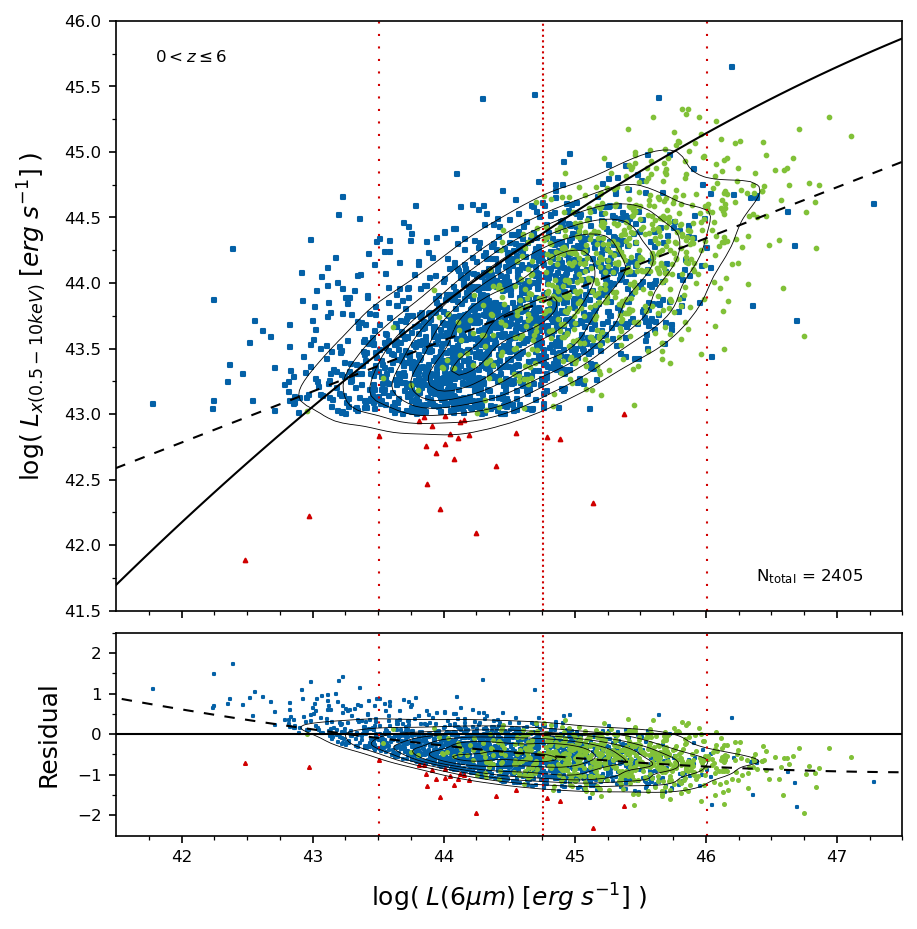

In [70]:
def PlotStern2015_res_fit(
    agnInfo_yX,
    agnInfo_nX,
    save = None,
    using210 = True,
    useSternAsBase = True
) :
    adp.SetStyle() 
    fig, ax = plt.subplots(nrows=2, ncols=1, layout='constrained', facecolor='w', sharex=True, 
                            gridspec_kw={'height_ratios': [3,1]}, figsize=(6,6.1))
    PlotTricolor_ax(
        ax=ax[0],
        x_red = agnInfo_yX['RED']['L(6um)'], 
        y_red = agnInfo_yX['RED']['Lx'],
        x_grn = agnInfo_yX['GRN']['L(6um)'], 
        y_grn = agnInfo_yX['GRN']['Lx'],
        x_blu = agnInfo_yX['BLU']['L(6um)'],  
        y_blu = agnInfo_yX['BLU']['Lx'],
        fullText = '$0 < z \leq 6$',
        using210 = using210,
    )
    # lables 
    if(using210):
        ax[0].set_ylabel('$\log( \; L_{x(2-10keV)} \; [erg \; s^{-1}] \;)$')
    else : 
        ax[0].set_ylabel('$\log( \; L_{x(0.5-10keV)} \; [erg \; s^{-1}] \;)$')

    # fit line 
    xAll = np.concatenate((agnInfo_yX['RED']['L(6um)'], agnInfo_yX['GRN']['L(6um)'], agnInfo_yX['BLU']['L(6um)']))
    yAll = np.concatenate((agnInfo_yX['RED']['Lx'], agnInfo_yX['GRN']['Lx'], agnInfo_yX['BLU']['Lx']))
    a, b = np.polyfit(xAll, yAll, 1)
    def fitline(x) : return (a*x+b)
    PlotLine(ax[0],a,b,40,50,(0, (5, 5)))

    # plot residual
    # # choose residual baseline  
    if(useSternAsBase) : 
        usefunc=FuncStern
        uselinestyle = '-'
        # add my fit to residual 
        xline = np.linspace(40,50)
        yfit = fitline(xline) - FuncStern(xline)
        ax[1].plot(xline,yfit, c='k', linestyle=(0, (5, 5))) # dashed
    else: 
        usefunc=fitline
        uselinestyle = '--'
        # add stern to residual 
        xline = np.linspace(40,50)
        ysternres = FuncStern(xline) - fitline(xline)
        ax[1].plot(xline,ysternres, c='k')
    # plot
    PlotResidual(
        ax=ax[1],
        x_red = agnInfo_yX['RED']['L(6um)'], 
        y_red = agnInfo_yX['RED']['Lx'],
        x_grn = agnInfo_yX['GRN']['L(6um)'], 
        y_grn = agnInfo_yX['GRN']['Lx'],
        x_blu = agnInfo_yX['BLU']['L(6um)'],  
        y_blu = agnInfo_yX['BLU']['Lx'],
        func  = usefunc,
        linestyle = uselinestyle
    ) 

    # AddRedBoxStuff(ax, agnInfo_nX)
    AddRedLineStuff(ax, agnInfo_nX_byZ) 

    # lables 
    ax[1].set_xlabel('$\log( \; L(6 \mu m) \; [erg \; s^{-1}] \;)$')
    ax[1].set_ylabel('Residual')
    # finish
    if(save): adp.Save(save)
    plt.show()
    plt.close()


# PlotStern2015_res_fit(
#             agnInfo_yX, 
#             agnInfo_nX_byZ,
#             # save=adp.path_fig + '\\v2_LxVsL6um_zAll_res_fit_myBase.png',
#             using210 = using210,
#             useSternAsBase = False
# )

PlotStern2015_res_fit(
            agnInfo_yX,
            agnInfo_nX_byZ,
            save=adp.path_fig + '\\v2_LxVsL6um_zAll_res_fit.png',
            using210 = using210,
            useSternAsBase = True
)


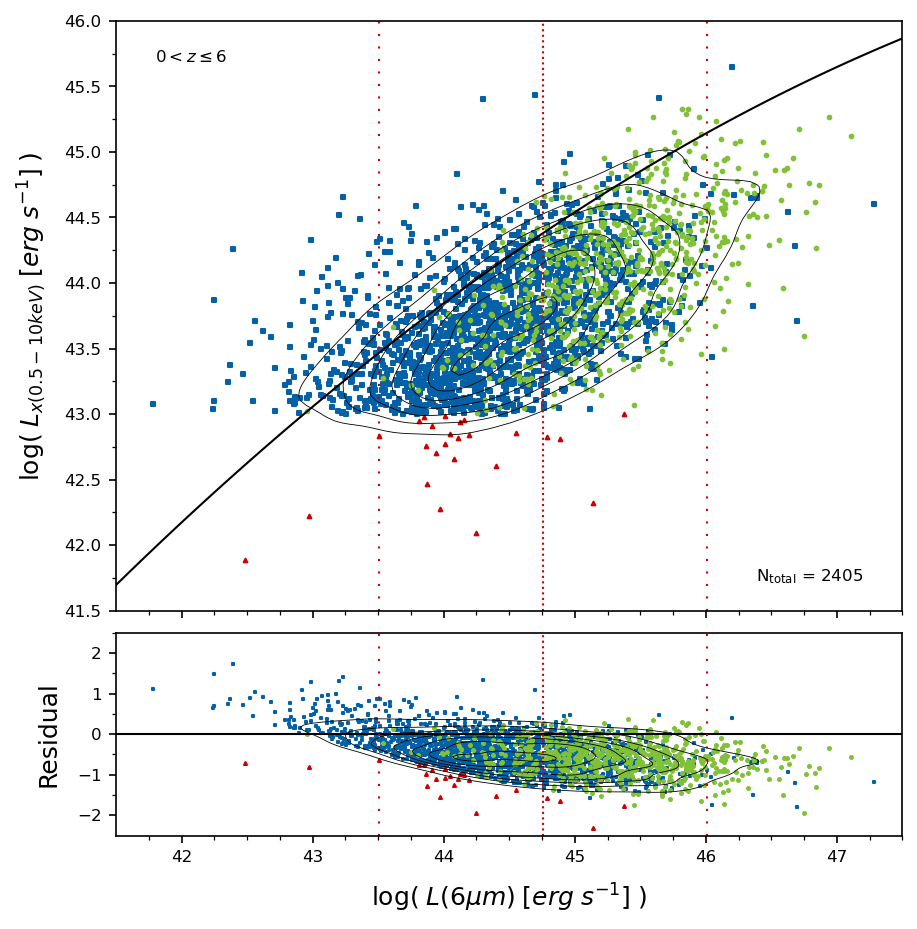

In [65]:
def PlotStern2015_res(
    agnInfo_yX, 
    agnInfo_nX_byZ,
    save = None,
    using210 = True,
) :
    adp.SetStyle() 
    fig, ax = plt.subplots(nrows=2, ncols=1, layout='constrained', facecolor='w', sharex=True, 
                            gridspec_kw={'height_ratios': [3,1]}, figsize=(6,6.1))
    PlotTricolor_ax(
        ax=ax[0],
        x_red = agnInfo_yX['RED']['L(6um)'], 
        y_red = agnInfo_yX['RED']['Lx'],
        x_grn = agnInfo_yX['GRN']['L(6um)'], 
        y_grn = agnInfo_yX['GRN']['Lx'],
        x_blu = agnInfo_yX['BLU']['L(6um)'],  
        y_blu = agnInfo_yX['BLU']['Lx'],
        fullText = '$0 < z \leq 6$',
        using210 = using210,
    )
    # lables 
    if(using210):
        ax[0].set_ylabel('$\log( \; L_{x(2-10keV)} \; [erg \; s^{-1}] \;)$')
    else : 
        ax[0].set_ylabel('$\log( \; L_{x(0.5-10keV)} \; [erg \; s^{-1}] \;)$')
    PlotResidual(
        ax=ax[1],
        x_red = agnInfo_yX['RED']['L(6um)'], 
        y_red = agnInfo_yX['RED']['Lx'],
        x_grn = agnInfo_yX['GRN']['L(6um)'], 
        y_grn = agnInfo_yX['GRN']['Lx'],
        x_blu = agnInfo_yX['BLU']['L(6um)'],  
        y_blu = agnInfo_yX['BLU']['Lx'],
    ) 
    # lables 
    ax[1].set_xlabel('$\log( \; L(6 \mu m) \; [erg \; s^{-1}] \;)$')
    ax[1].set_ylabel('Residual')
    # extra decorations
    AddRedLineStuff(ax, agnInfo_nX_byZ) 
    # finish
    if(save): adp.Save(save)
    plt.show()
    plt.close()

PlotStern2015_res(agnInfo_yX, agnInfo_nX_byZ,
              save=adp.path_fig + '\\v2_LxVsL6um_zAll_res.png',
              using210 = using210)

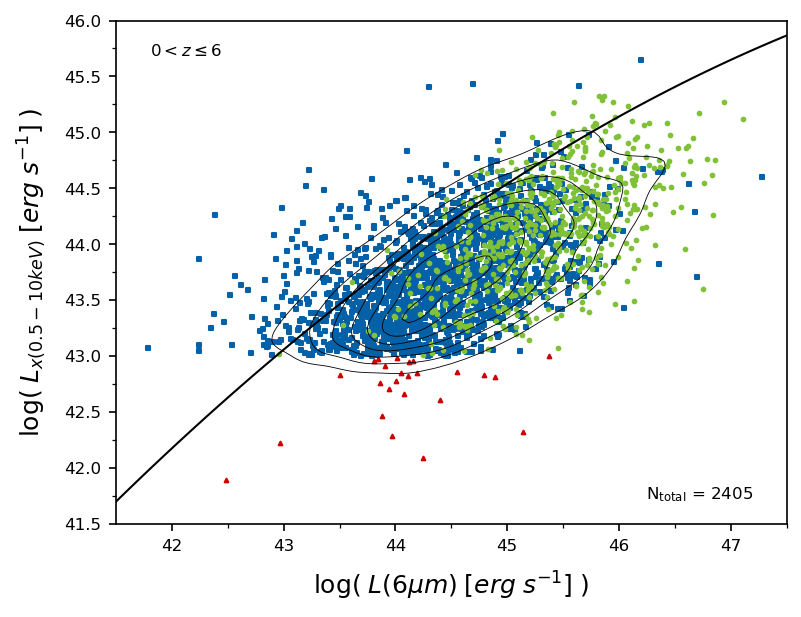

In [48]:
def PlotStern2015(
    agnInfo_yX,
    save = None,
    using210 = True
) :
    adp.SetStyle() 
    fig, ax = plt.subplots(layout='constrained', facecolor='w')
    PlotTricolor_ax(
        ax=ax,
        x_red = agnInfo_yX['RED']['L(6um)'], 
        y_red = agnInfo_yX['RED']['Lx'],
        x_grn = agnInfo_yX['GRN']['L(6um)'], 
        y_grn = agnInfo_yX['GRN']['Lx'],
        x_blu = agnInfo_yX['BLU']['L(6um)'],  
        y_blu = agnInfo_yX['BLU']['Lx'],
        fullText = '$0 < z \leq 6$',
        using210 = using210
    )
    # lables 
    if(using210):
        ax.set_ylabel('$\log( \; L_{x(2-10keV)} \; [erg \; s^{-1}] \;)$')
    else : 
        ax.set_ylabel('$\log( \; L_{x(0.5-10keV)} \; [erg \; s^{-1}] \;)$')
    ax.set_xlabel('$\log( \; L(6 \mu m) \; [erg \; s^{-1}] \;)$')
    # finish
    if(save): adp.Save(save)
    plt.show()
    plt.close()

PlotStern2015(agnInfo_yX,
              save=adp.path_fig + '\\v2_LxVsL6um_zAll.png',
              using210 = using210,
             )

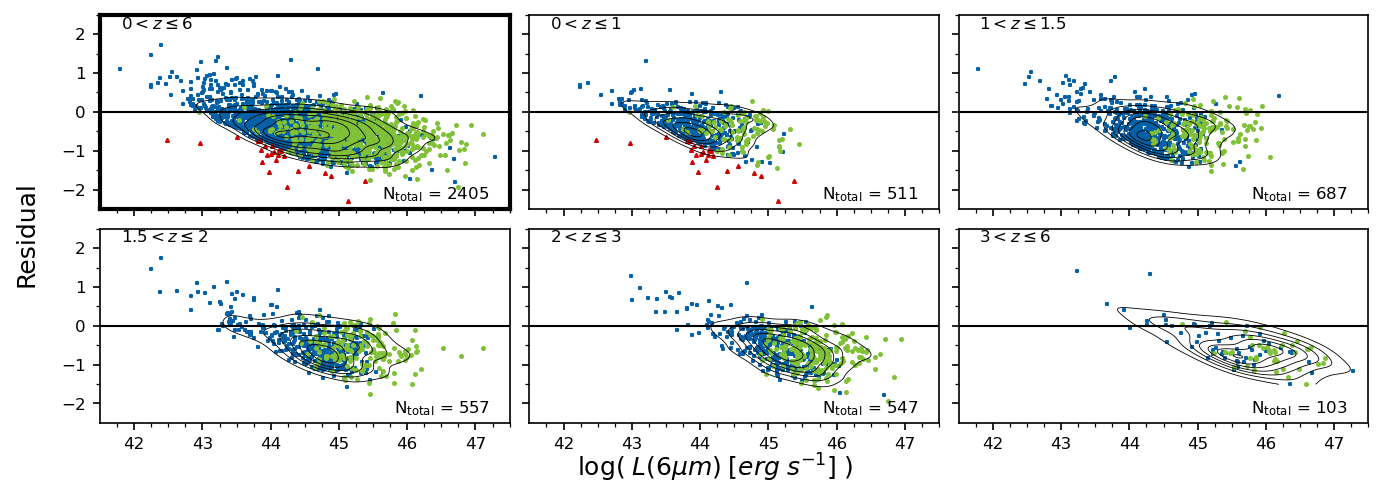

In [49]:
def PlotStern2015_res_rectangle(
    agnInfo_yX,
    agnInfo_yX_byZ,
    save = None,
    using210 = True
) :
    # setup plot 
    fig, ax = adp.ByZ_SetupFig_Rectangle(2,3)
    fig.set_figheight((2*1.5))    
    fig.set_figwidth((3*3)-0.2)   

    # plot all 
    adp.BoldSubplot(ax[0][0])
    PlotResidual(
        ax=ax[0][0],
        x_red = agnInfo_yX['RED']['L(6um)'], 
        y_red = agnInfo_yX['RED']['Lx'],
        x_grn = agnInfo_yX['GRN']['L(6um)'], 
        y_grn = agnInfo_yX['GRN']['Lx'],
        x_blu = agnInfo_yX['BLU']['L(6um)'],  
        y_blu = agnInfo_yX['BLU']['Lx'],
        nText = True,
        zText = '$0 < z \leq 6$',
    )
    # make plot for each redshift range
    row = 0
    col = 1
    z = ['$0 < z \leq 1$','$1 < z \leq 1.5$','$1.5 < z \leq 2$' ,'$2 < z \leq 3$','$3 < z \leq 6$'   ]
    for zrange in z :  
        PlotResidual(
            ax=ax[row][col],
            x_red = agnInfo_yX_byZ['RED'][zrange]['L(6um)'], 
            y_red = agnInfo_yX_byZ['RED'][zrange]['Lx'],
            x_grn = agnInfo_yX_byZ['GRN'][zrange]['L(6um)'], 
            y_grn = agnInfo_yX_byZ['GRN'][zrange]['Lx'],
            x_blu = agnInfo_yX_byZ['BLU'][zrange]['L(6um)'],  
            y_blu = agnInfo_yX_byZ['BLU'][zrange]['Lx'],
            nText = True,
            zText = zrange
        )
        # increment plot
        if(col < 2) : 
            col += 1
        else : 
            col = 0
            row +=1
        plt.xlabel('')
    
    if(using210):
        adp.ByZ_FinishPlot(
            fig,
            '$\log( \; L(6 \mu m) \; [erg \; s^{-1}] \;)$',
            'Residual',
            save, (0.5, -0.04), (-0.03, 0.5)
        )
    else:
        adp.ByZ_FinishPlot(
            fig,
            '$\log( \; L(6 \mu m) \; [erg \; s^{-1}] \;)$',
            'Residual',
            save, (0.5, -0.04), (-0.03, 0.5)
        )

PlotStern2015_res_rectangle(
    agnInfo_yX,
    agnInfo_yX_byZ,
    save=adp.path_fig + '\\v2_LxVsL6um_res_rect.png'
)

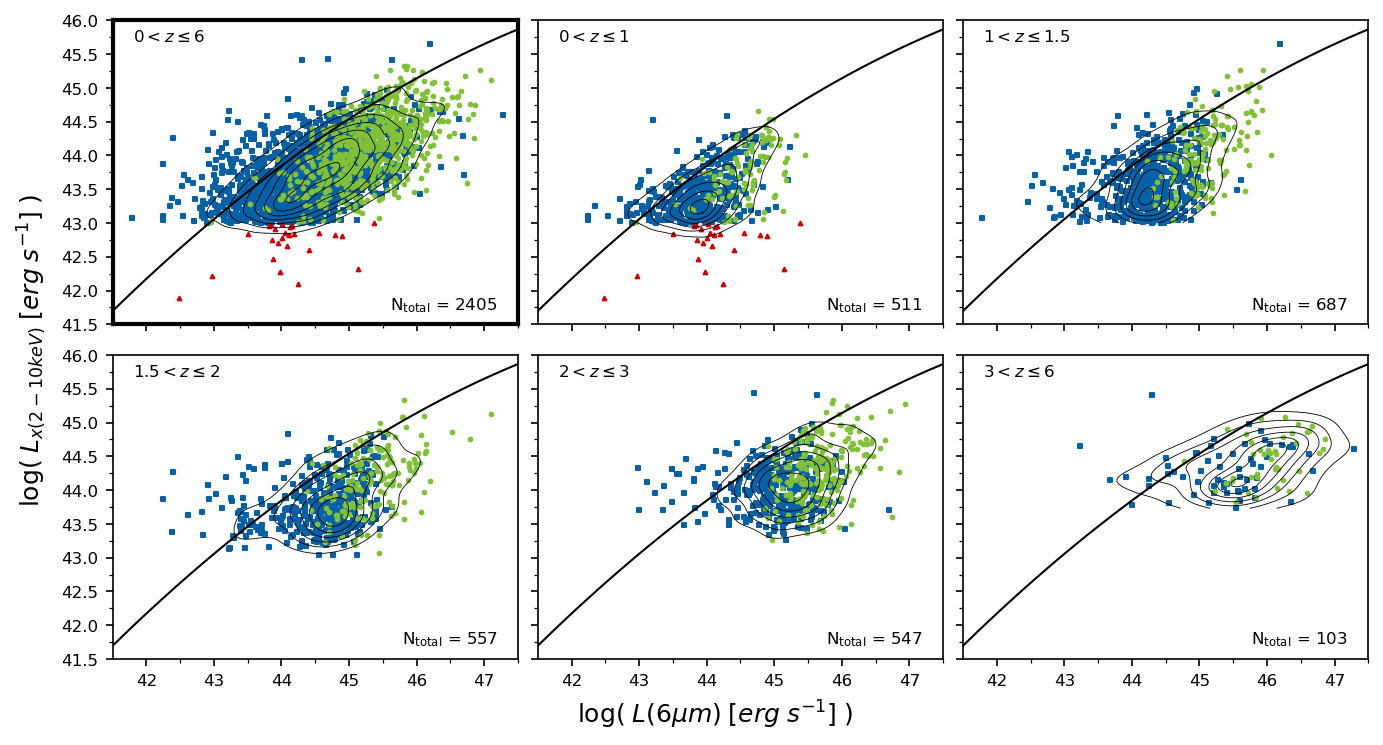

In [50]:
def PlotStern2015_rectangle(
    agnInfo_yX,
    agnInfo_yX_byZ,
    save = None,
    using210 = True
) :
    # setup plot 
    fig, ax = adp.ByZ_SetupFig_Rectangle(2,3)
    fig.set_figheight((2*2.3))    
    fig.set_figwidth((3*3)-0.2)   

    # plot all 
    adp.BoldSubplot(ax[0][0])
    PlotTricolor_ax(
        ax=ax[0][0],
        x_red = agnInfo_yX['RED']['L(6um)'], 
        y_red = agnInfo_yX['RED']['Lx'],
        x_grn = agnInfo_yX['GRN']['L(6um)'], 
        y_grn = agnInfo_yX['GRN']['Lx'],
        x_blu = agnInfo_yX['BLU']['L(6um)'],  
        y_blu = agnInfo_yX['BLU']['Lx'],
        fullText = '$0 < z \leq 6$',
        using210 = using210
    )

    # make plot for each redshift range
    row = 0
    col = 1
    z = ['$0 < z \leq 1$','$1 < z \leq 1.5$','$1.5 < z \leq 2$' ,'$2 < z \leq 3$','$3 < z \leq 6$'   ]
    for zrange in z :  
        PlotTricolor_ax(
            ax=ax[row][col],
            x_red = agnInfo_yX_byZ['RED'][zrange]['L(6um)'], 
            y_red = agnInfo_yX_byZ['RED'][zrange]['Lx'],
            x_grn = agnInfo_yX_byZ['GRN'][zrange]['L(6um)'], 
            y_grn = agnInfo_yX_byZ['GRN'][zrange]['Lx'],
            x_blu = agnInfo_yX_byZ['BLU'][zrange]['L(6um)'],  
            y_blu = agnInfo_yX_byZ['BLU'][zrange]['Lx'],
            fullText=zrange
        )
        # increment plot
        if(col < 2) : 
            col += 1
        else : 
            col = 0
            row +=1
        plt.xlabel('')
    
    if(using210):
        adp.ByZ_FinishPlot(
            fig,
            '$\log( \; L(6 \mu m) \; [erg \; s^{-1}] \;)$',
            '$\log( \; L_{x(2-10keV)} \; [erg \; s^{-1}] \;)$',
            save, (0.5, -0.04), (-0.03, 0.5)
        )
    else:
        adp.ByZ_FinishPlot(
            fig,
            '$\log( \; L(6 \mu m) \; [erg \; s^{-1}] \;)$',
            '$\log( \; L_{x(0.5-10keV)} \; [erg \; s^{-1}] \;)$',
            save, (0.5, -0.04), (-0.03, 0.5)
        )

PlotStern2015_rectangle(
    agnInfo_yX,
    agnInfo_yX_byZ,
    save=adp.path_fig + '\\v2_LxVsL6um_rect.png'
)

# Histogram

In [54]:
def PlotL6umHist(ax, x: list, c: list, textN=True, fullText='$0 < z \leq 1$', h=225, xtext=0.98) :
    ax.set_ylim(ymin=0, ymax=h)
    Ntot = 0
    lableHight = 0.94
    for xi, ci in zip(x,c) :
        if(len(xi)!=0) :
            ax.hist(xi, histtype='step', color=ci, linewidth=2)
            adp.MeanLineForHist_ax(ax=ax,x=xi,c=ci,xtext=xtext,ytext=lableHight,horizAlign='right',pre='')
            Ntot += len(xi)
            lableHight -= 0.05
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    if(textN) : adp.AddText_n_ax(ax,Ntot)
    adp.AddText_z_ax(ax, fullText=fullText)

In [ ]:
# def AddRedLineStuff(ax, agnInfo_nX_byZ) : 
#     # collect data
#     nx = np.array([])
#     for zrange, agninfodict in agnInfo_nX_byZ['RED'].items() : 
#         nx = np.concatenate((nx,agninfodict['L(6um)']))
#     # stats
#     center = np.mean(nx)
#     std = np.std(nx) 
#     print('STATS:\t', center-std, center, center+std)
#     print('STERN:\t', FuncStern(center-std), FuncStern(center), FuncStern(center+std))
#     for axi in ax : 
#         # draw average line 
#         axi.axvline( center, 0,1, c=adp.c_ir, linewidth=1, linestyle='dotted' )
#         # draw 1 std dev from mean 
#         axi.axvline( center+std, 0,1, c=adp.c_ir, linewidth=1, linestyle=(0, (1, 5)) ) # spaced dotted line
#         axi.axvline( center-std, 0,1, c=adp.c_ir, linewidth=1, linestyle=(0, (1, 5)) )


STATS:	 43.50333493736798 44.756168330298806 46.00900172322963
STERN:	 43.464724590906094 44.379046593573314 45.145826994258925


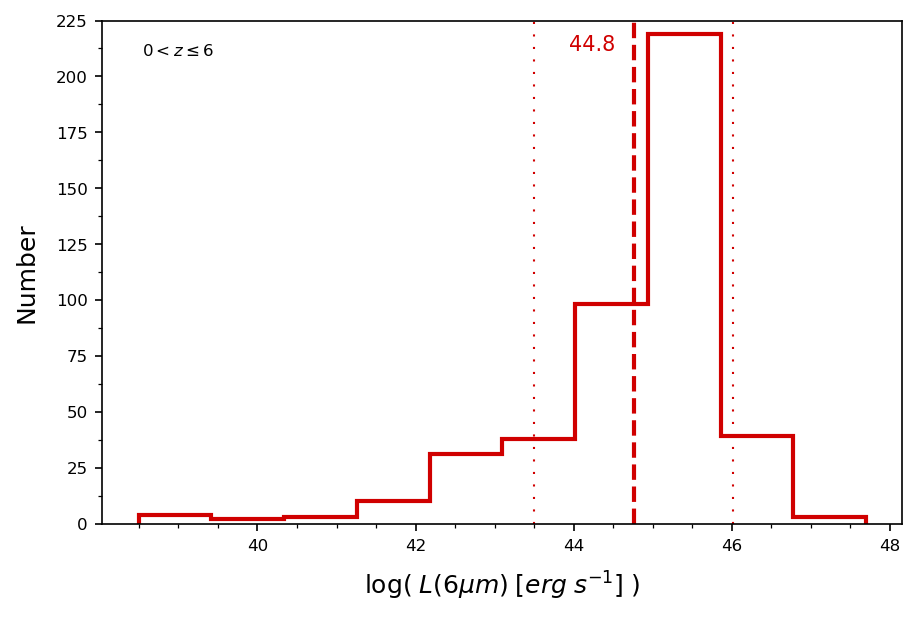

In [71]:
def ShowL6umForNX(agnInfo_nX_byZ, save=None) : 
    adp.SetStyle() 
    fig, ax = plt.subplots(layout='constrained', facecolor='w')
    # get data
    x = np.array([])
    for zrange, agninfodict in agnInfo_nX_byZ['RED'].items() : 
        x = np.concatenate((x,agninfodict['L(6um)']))
    # plot
    PlotL6umHist(ax, [x],[adp.c_ir], fullText='$0 < z \leq 6$',textN=False,xtext=0.995)

    # extra stats
    center = np.mean(x)
    std = np.std(x) 
    print('STATS:\t', center-std, center, center+std)
    print('STERN:\t', FuncStern(center-std), FuncStern(center), FuncStern(center+std))
    # draw 1 std dev from mean 
    ax.axvline( center+std, 0,1, c=adp.c_ir, linewidth=1, linestyle=(0, (1, 5)) ) # spaced dotted line
    ax.axvline( center-std, 0,1, c=adp.c_ir, linewidth=1, linestyle=(0, (1, 5)) )

    # lables 
    plt.xlabel('$\log( \; L(6 \mu m) \; [erg \; s^{-1}] \;)$')
    plt.ylabel('Number')
    # finish
    if(save): adp.Save(save)
    plt.show()
    plt.close()

if(not using210): 
    ShowL6umForNX(
        agnInfo_nX_byZ,
        save=adp.path_fig + '\\v2_L6um_noLx_hist_justRED.png'    
    )

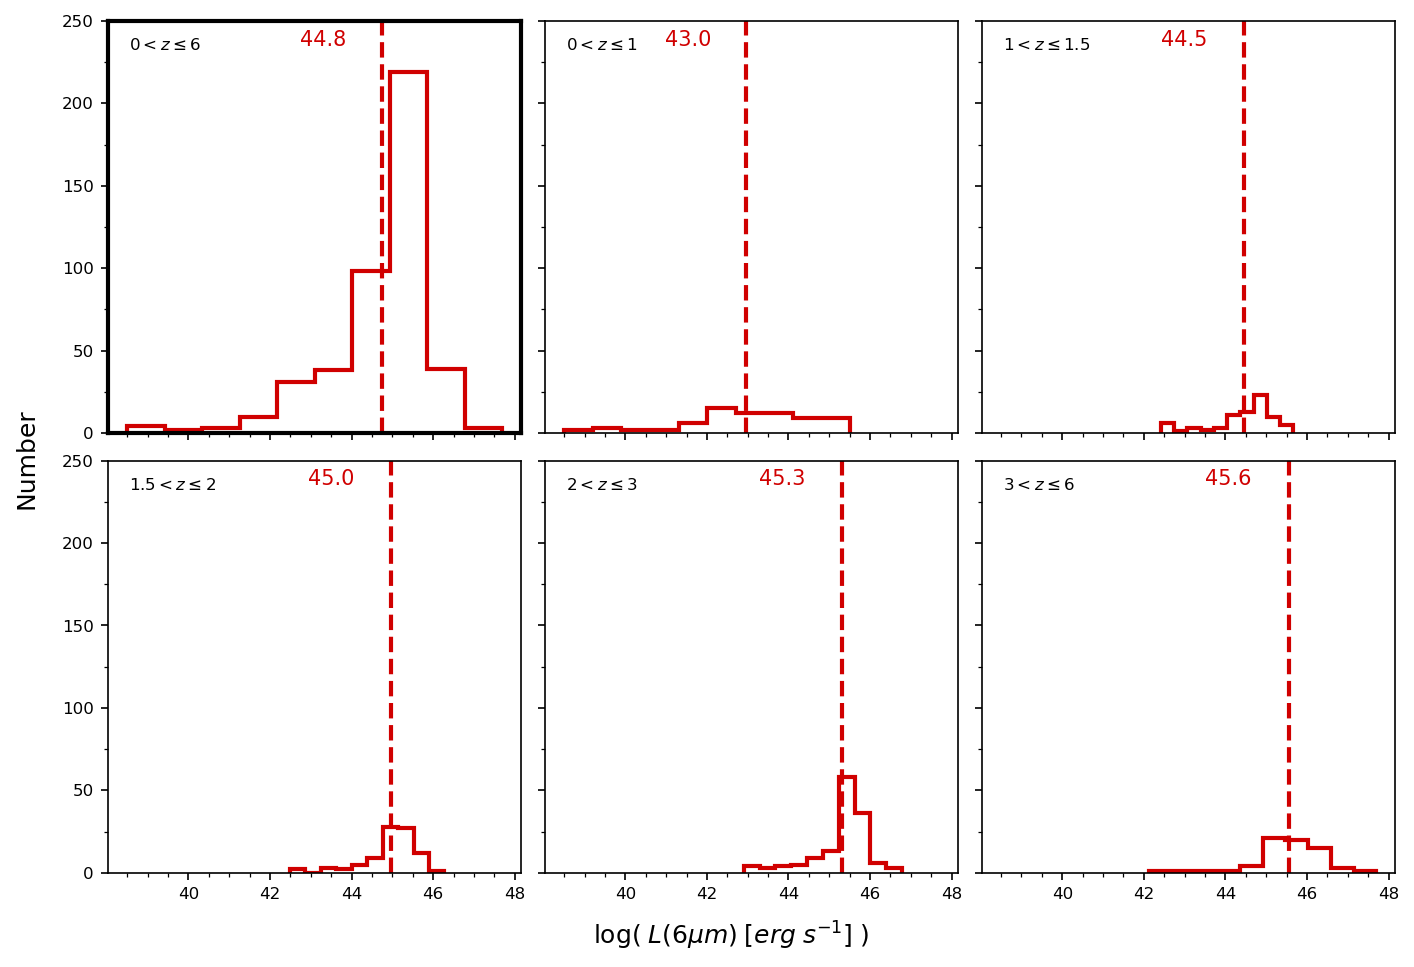

In [26]:
def PlotStern2015_rectangle(
    agnInfo_nX,
    agnInfo_nX_byZ,
    save = None,
) :
    # setup plot 
    fig, ax = adp.ByZ_SetupFig_Rectangle(2,3)

    # plot all 
    adp.BoldSubplot(ax[0][0])
    PlotL6umHist(ax[0][0],
                 [agnInfo_nX['RED']['L(6um)'],agnInfo_nX['GRN']['L(6um)'],agnInfo_nX['BLU']['L(6um)']],
                 [adp.c_ir, adp.c_ir_xray, adp.c_xray],
                 fullText='$0 < z \leq 6$', 
                 h=250, textN=False)

    # make plot for each redshift range
    row = 0
    col = 1
    z = ['$0 < z \leq 1$','$1 < z \leq 1.5$','$1.5 < z \leq 2$' ,'$2 < z \leq 3$','$3 < z \leq 6$'   ]
    for zrange in z :  
        PlotL6umHist(ax[row][col],
                 [agnInfo_nX_byZ['RED'][zrange]['L(6um)'],
                  agnInfo_nX_byZ['GRN'][zrange]['L(6um)'],
                  agnInfo_nX_byZ['BLU'][zrange]['L(6um)']],
                 [adp.c_ir, adp.c_ir_xray, adp.c_xray],
                 fullText=zrange,
                 h=250, textN=False)
        # increment plot
        if(col < 2) : 
            col += 1
        else : 
            col = 0
            row +=1
    
    adp.ByZ_FinishPlot(
        fig,
        '$\log( \; L(6 \mu m) \; [erg \; s^{-1}] \;)$',
        'Number',
        save, (0.5, -0.04), (-0.03, 0.5)
    )

PlotStern2015_rectangle(
    agnInfo_nX,
    agnInfo_nX_byZ,
    save=adp.path_fig + '\\v2_L6um_noLx_hist.png'    
)